# Feature Engeneering for ride duration of taxi trips in New York City

In this notebook we explore feature extraction to build a model that predicts the total ride duration of taxi trips in New York City. We are using data from a Kaggle competition (https://www.kaggle.com/c/nyc-taxi-trip-duration/).

In [3]:
%matplotlib inline
import numpy as np 
import pandas as pd
from datetime import timedelta
import datetime as dt
import matplotlib.pyplot as plt
import xgboost as xgb
from sklearn.cluster import MiniBatchKMeans
import warnings

In [4]:
plt.rcParams['figure.figsize'] = [13, 5]

## Initail data exploration

In [5]:
path = "/Users/Shikhar/data/nyc_taxi/"

In [6]:
train = pd.read_csv(path + 'train.csv')
test = pd.read_csv(path + 'test.csv')

In [7]:
train.shape

(1458644, 11)

In [8]:
train.head()

,id,vendor_id,pickup_datetime,dropoff_datetime,passenger_count,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,store_and_fwd_flag,trip_duration
0,id2875421,2,2016-03-14 17:24:55,2016-03-14 17:32:30,1,-73.982155,40.767937,-73.964630,40.765602,N,455
1,id2377394,1,2016-06-12 00:43:35,2016-06-12 00:54:38,1,-73.980415,40.738564,-73.999481,40.731152,N,663
2,id3858529,2,2016-01-19 11:35:24,2016-01-19 12:10:48,1,-73.979027,40.763939,-74.005333,40.710087,N,2124
3,id3504673,2,2016-04-06 19:32:31,2016-04-06 19:39:40,1,-74.010040,40.719971,-74.012268,40.706718,N,429
4,id2181028,2,2016-03-26 13:30:55,2016-03-26 13:38:10,1,-73.973053,40.793209,-73.972923,40.782520,N,435


Data Description
* id - a unique identifier for each trip
* vendor_id - a code indicating the provider associated with the trip record
* pickup_datetime - date and time when the meter was engaged
* dropoff_datetime - date and time when the meter was disengaged
* passenger_count - the number of passengers in the vehicle (driver entered value)
* pickup_longitude - the longitude where the meter was engaged
* pickup_latitude - the latitude where the meter was engaged
* dropoff_longitude - the longitude where the meter was disengaged
* dropoff_latitude - the latitude where the meter was disengaged
* store_and_fwd_flag - This flag indicates whether the trip record was held in vehicle memory before sending to the vendor because the vehicle did not have a connection to the server (Y=store and forward; N=not a store and forward trip)
* trip_duration - duration of the trip in seconds

### Cleaning and transforming target variable

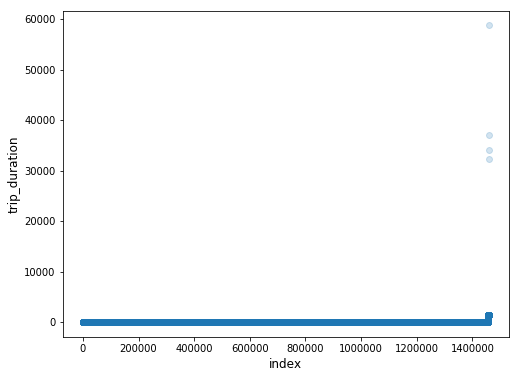

In [9]:
# let's look at the target variable
plt.figure(figsize=(8,6))
plt.scatter(range(train.shape[0]), np.sort(train["trip_duration"].values/60), alpha=0.2)
plt.xlabel('index', fontsize=12)
plt.ylabel('trip_duration', fontsize=12)
plt.show()

In [8]:
# initial cleaning
train["trip_duration"].quantile([.0, 0.01, 0.25, .5, 0.75, 0.99, 1])

0.00          1.0
0.01         87.0
0.25        397.0
0.50        662.0
0.75       1075.0
0.99       3440.0
1.00    3526282.0
Name: trip_duration, dtype: float64

In [15]:
# The 99 quantile is 57. 3 minutes 
# clipping trips logger than one hour  
train.loc[train["trip_duration"] > 60*60, "trip_duration"] = 60*60

# clipping trips less that one minute  
train.loc[train["trip_duration"] < 60, "trip_duration"] = 60

print(train.shape)

(1458644, 11)


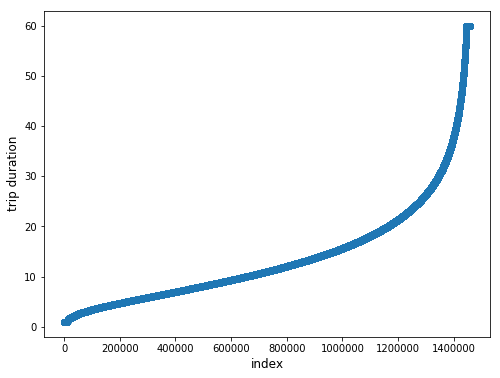

In [16]:
plt.figure(figsize=(8,6))
plt.scatter(range(train.shape[0]), np.sort(train["trip_duration"].values/60), alpha=0.2)
plt.xlabel('index', fontsize=12)
plt.ylabel('trip duration', fontsize=12)
plt.show()

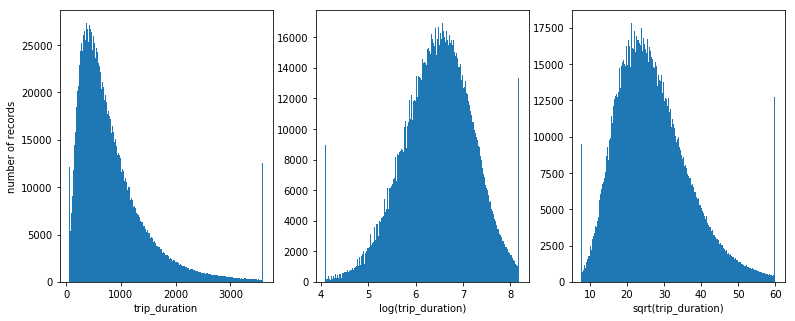

In [17]:
# It may be a good idea to transform the "y" variable
# Look for a transformation that give you a plot closer to a normal
train['log_trip_duration'] = np.log(train['trip_duration'].values)
train['sqrt_trip_duration'] = np.sqrt(train['trip_duration'].values)
fig, ax = plt.subplots(ncols=3, sharex=False, sharey=False)
ax[0].hist(train['trip_duration'].values, bins=200)
ax[1].hist(train['log_trip_duration'].values, bins=200)
ax[2].hist(train['sqrt_trip_duration'].values, bins=200)
ax[0].set_ylabel('number of records')
ax[0].set_xlabel('trip_duration')
ax[1].set_xlabel('log(trip_duration)')
ax[2].set_xlabel('sqrt(trip_duration)')
plt.show()

## Distance & Speed

In [18]:
train['pickup_datetime'] = pd.to_datetime(train.pickup_datetime)
test['pickup_datetime'] = pd.to_datetime(test.pickup_datetime)

In [19]:
train.head()

,id,vendor_id,pickup_datetime,dropoff_datetime,passenger_count,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,store_and_fwd_flag,trip_duration,log_trip_duration,sqrt_trip_duration
0,id2875421,2,2016-03-14 17:24:55,2016-03-14 17:32:30,1,-73.982155,40.767937,-73.964630,40.765602,N,455,6.120297,21.330729
1,id2377394,1,2016-06-12 00:43:35,2016-06-12 00:54:38,1,-73.980415,40.738564,-73.999481,40.731152,N,663,6.496775,25.748786
2,id3858529,2,2016-01-19 11:35:24,2016-01-19 12:10:48,1,-73.979027,40.763939,-74.005333,40.710087,N,2124,7.661056,46.086874
3,id3504673,2,2016-04-06 19:32:31,2016-04-06 19:39:40,1,-74.010040,40.719971,-74.012268,40.706718,N,429,6.061457,20.712315
4,id2181028,2,2016-03-26 13:30:55,2016-03-26 13:38:10,1,-73.973053,40.793209,-73.972923,40.782520,N,435,6.075346,20.856654


In [20]:
# this formulas accepts nump arrays
from math import radians, cos, sin, asin, sqrt

def L2_distance(lon1, lat1, lon2, lat2):
    """ Approximate distance
    """
    dlon = (lon2 - lon1)**2 
    dlat = (lat2 - lat1)**2
    return 1000*np.sqrt(dlon + dlat)

In [21]:
def compute_distance(df):
    lon1 = df['pickup_longitude'].values
    lat1 = df['pickup_latitude'].values
    lon2 = df['dropoff_longitude'].values
    lat2 = df['dropoff_latitude'].values
    return L2_distance(lon1, lat1, lon2, lat2)

In [22]:
train['distance'] = compute_distance(train)
test['distance'] = compute_distance(test)

In [23]:
train.describe()

,vendor_id,passenger_count,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,trip_duration,log_trip_duration,sqrt_trip_duration,distance
count,1.458644e+06,1.458644e+06,1.458644e+06,1.458644e+06,1.458644e+06,1.458644e+06,1.458644e+06,1.458644e+06,1.458644e+06,1.458644e+06
mean,1.534950e+00,1.664530e+00,-7.397349e+01,4.075092e+01,-7.397342e+01,4.075180e+01,8.354563e+02,6.465324e+00,2.712671e+01,3.548232e+01
std,4.987772e-01,1.314242e+00,7.090186e-02,3.288119e-02,7.064327e-02,3.589056e-02,6.356312e+02,7.494093e-01,9.979872e+00,4.596807e+01
min,1.000000e+00,0.000000e+00,-1.219333e+02,3.435970e+01,-1.219333e+02,3.218114e+01,6.000000e+01,4.094345e+00,7.745967e+00,0.000000e+00
25%,1.000000e+00,1.000000e+00,-7.399187e+01,4.073735e+01,-7.399133e+01,4.073588e+01,3.970000e+02,5.983936e+00,1.992486e+01,1.258443e+01
50%,2.000000e+00,1.000000e+00,-7.398174e+01,4.075410e+01,-7.397975e+01,4.075452e+01,6.620000e+02,6.495266e+00,2.572936e+01,2.121671e+01
75%,2.000000e+00,2.000000e+00,-7.396733e+01,4.076836e+01,-7.396301e+01,4.076981e+01,1.075000e+03,6.980076e+00,3.278719e+01,3.840884e+01
max,2.000000e+00,9.000000e+00,-6.133553e+01,5.188108e+01,-6.133553e+01,4.392103e+01,3.600000e+03,8.188689e+00,6.000000e+01,1.119260e+04


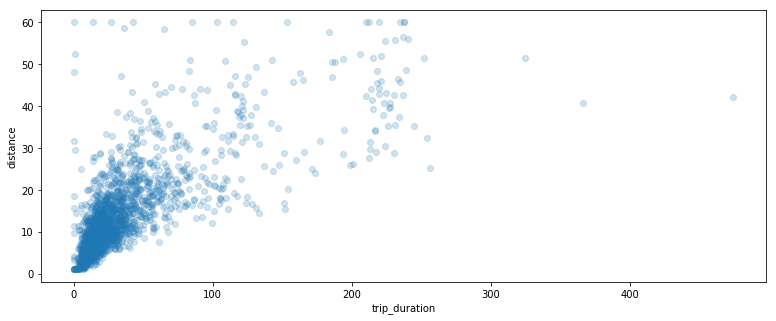

array([[ 1.        ,  0.73845563],
       [ 0.73845563,  1.        ]])

In [24]:
y = train['trip_duration'][:2000]/60
x = train['distance'][:2000]
plt.scatter(x, y, alpha=0.2)
plt.xlabel('trip_duration')
plt.ylabel('distance')
plt.show()
np.corrcoef(x,y)

In [25]:
# ?miles an hour
train["speed"] = train["distance"]/ (train["trip_duration"] / 360.0)

Note that 'speed' is not a feature since it needs trip duration which is the target variable.
We are using it just as part of our exploration

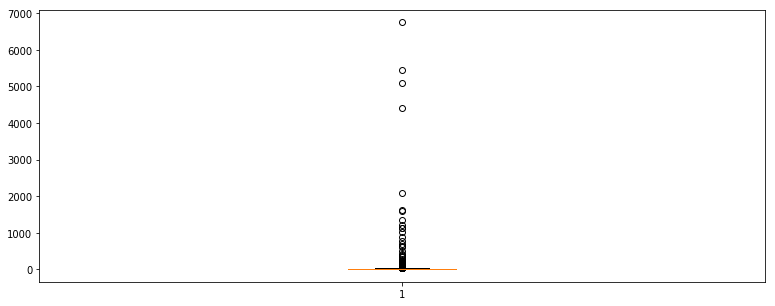

In [26]:
plt.boxplot(train['speed'])
plt.show()

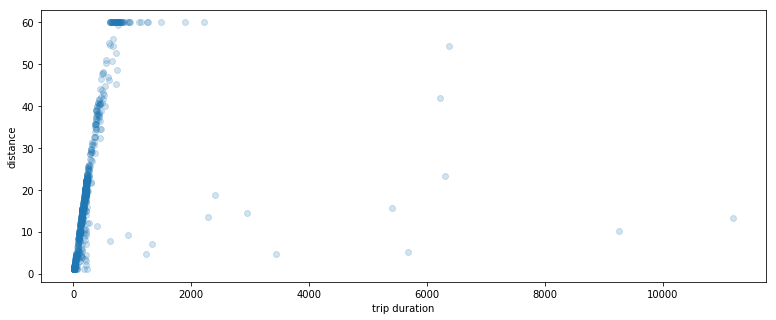

In [27]:
tmp = train[train['speed'] > 60]
y = tmp['trip_duration']/60
x = tmp['distance']
plt.scatter(x, y, alpha=0.2)
plt.xlabel('trip duration')
plt.ylabel('distance')
plt.show()

In [28]:
# some more clipping here
train['speed'].quantile([.0, 0.25, .5, 0.75, 0.999, 1])

0.000       0.000000
0.250       9.276128
0.500      12.943377
0.750      18.009364
0.999      55.959545
1.000    6749.747037
Name: speed, dtype: float64

In [29]:
ind = train['speed'] > 60
v = train.loc[ind, 'distance']/60

In [30]:
train.loc[ind, "trip_duration"] = v

In [31]:
train.shape

(1458644, 15)

## Time features

We will define some time features. By plotting every feature agains the "trip_duration" or "speed" we will be able to see if there is any useful correlations. 

In [32]:
def get_time_features(df):
    df['pickup_weekday'] = df['pickup_datetime'].dt.weekday
    df['pickup_weekofyear'] = df['pickup_datetime'].dt.weekofyear
    df['pickup_hour'] = df['pickup_datetime'].dt.hour
    df['pickup_week_hour'] = df['pickup_weekday'] * 24 + df['pickup_hour']
    return df

In [33]:
train = get_time_features(train)
test = get_time_features(test)

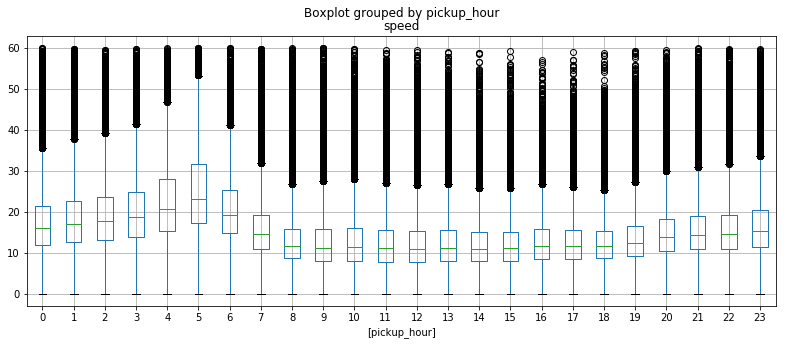

In [34]:
tmp = train[train['speed'] < 60]
metric = 'pickup_hour'
y = 'speed'
tmp.boxplot(column=y, by=[metric])

Looks like speed is lower in the middle of the day which makes pickup hour a likely useful feature.

Plot other features. Do they seem useful?

## Clustering based on lat and long

In [35]:
places = np.vstack((train[['pickup_latitude', 'pickup_longitude']].values,
                    train[['dropoff_latitude', 'dropoff_longitude']].values))

In [36]:
places.shape

(2917288, 2)

In [37]:
places

array([[ 40.76793671, -73.98215485],
       [ 40.73856354, -73.98041534],
       [ 40.7639389 , -73.97902679],
       ..., 
       [ 40.70737076, -74.00443268],
       [ 40.75710678, -73.97463226],
       [ 40.79058456, -73.97280884]])

In [38]:
kmeans = MiniBatchKMeans(n_clusters=100, batch_size=10000).fit(places)

In [39]:
# here the new features is the id of the cluster
# here the new features is the id of the cluster
train['pickup_cluster'] = kmeans.predict(train[['pickup_latitude', 'pickup_longitude']])
train['dropoff_cluster'] = kmeans.predict(train[['dropoff_latitude', 'dropoff_longitude']])
test['pickup_cluster'] = kmeans.predict(test[['pickup_latitude', 'pickup_longitude']])
test['dropoff_cluster'] = kmeans.predict(test[['dropoff_latitude', 'dropoff_longitude']])

In [40]:
train.head()

,id,vendor_id,pickup_datetime,dropoff_datetime,passenger_count,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,store_and_fwd_flag,...,log_trip_duration,sqrt_trip_duration,distance,speed,pickup_weekday,pickup_weekofyear,pickup_hour,pickup_week_hour,pickup_cluster,dropoff_cluster
0,id2875421,2,2016-03-14 17:24:55,2016-03-14 17:32:30,1,-73.982155,40.767937,-73.964630,40.765602,N,...,6.120297,21.330729,17.679539,13.988207,0,11,17,17,31,59
1,id2377394,1,2016-06-12 00:43:35,2016-06-12 00:54:38,1,-73.980415,40.738564,-73.999481,40.731152,N,...,6.496775,25.748786,20.455904,11.107278,6,23,0,144,83,4
2,id3858529,2,2016-01-19 11:35:24,2016-01-19 12:10:48,1,-73.979027,40.763939,-74.005333,40.710087,N,...,7.661056,46.086874,59.933799,10.158271,1,3,11,35,75,15
3,id3504673,2,2016-04-06 19:32:31,2016-04-06 19:39:40,1,-74.010040,40.719971,-74.012268,40.706718,N,...,6.061457,20.712315,13.438206,11.276816,2,14,19,67,34,15
4,id2181028,2,2016-03-26 13:30:55,2016-03-26 13:38:10,1,-73.973053,40.793209,-73.972923,40.782520,N,...,6.075346,20.856654,10.689569,8.846540,5,12,13,133,16,48


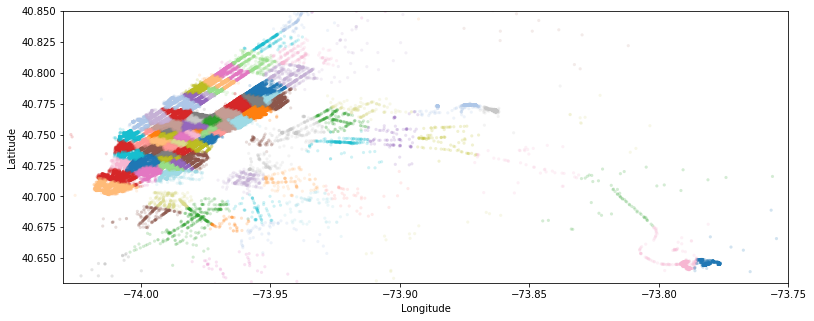

In [41]:
N = 100000
city_long_border = (-74.03, -73.75)
city_lat_border = (40.63, 40.85)
fig, ax = plt.subplots(ncols=1, nrows=1)
ax.scatter(train.pickup_longitude.values[:N], train.pickup_latitude.values[:N], s=10, lw=0,
           c=train.pickup_cluster[:N].values, cmap='tab20', alpha=0.2)
ax.set_xlim(city_long_border)
ax.set_ylim(city_lat_border)
ax.set_xlabel('Longitude')
ax.set_ylabel('Latitude')
plt.show()
#There are some weird outliers here

## Split train and validation

In [55]:
# split train and validation
np.random.seed(3)
msk = np.random.rand(len(train)) < 0.8
train_set = train[msk].copy()
val_set = train[~msk].copy()
print(train_set.shape, val_set.shape)

(1165908, 21) (292736, 21)


## Target Encoding (naive version)

Here is an example of what is called 'Target Encoding'. The idea here is given a categorical variable, create a new variable that is the mean each categorical value variable in the training data. This is a naive version of target encoding. We will discuss a better version next class.

Note that I divided the train and validation sets before doing this. Since the computation of these involve the target variable, we do it in the training and transfer it to the test/ validation sets.

In [56]:
col = 'pickup_weekday'
gby = train_set.groupby(col).mean()[['speed', 'log_trip_duration']]
gby.columns = ['%s_gby_%s' % (c, col) for c in gby.columns]
gby

,speed_gby_pickup_weekday,log_trip_duration_gby_pickup_weekday
pickup_weekday,,
0,15.391604,6.426236
1,13.965800,6.489996
2,13.740403,6.511811
3,13.672504,6.526877
4,13.963899,6.497713
5,15.167796,6.415824
6,16.935512,6.374934


In [57]:
for col in ['pickup_weekday', 'pickup_weekofyear', 'pickup_hour',
       'pickup_week_hour', 'pickup_cluster', 'dropoff_cluster']:
    gby = train_set.groupby(col).mean()[['speed', 'log_trip_duration']]
    gby.columns = ['%s_gby_%s' % (c, col) for c in gby.columns]
    train_set = pd.merge(train_set, gby, how='left', left_on=col, right_index=True)
    val_set = pd.merge(val_set, gby, how='left', left_on=col, right_index=True)
    test = pd.merge(test, gby, how='left', left_on=col, right_index=True)

In [58]:
train_set.isnull().any()

id                                         False
vendor_id                                  False
pickup_datetime                            False
dropoff_datetime                           False
passenger_count                            False
pickup_longitude                           False
pickup_latitude                            False
dropoff_longitude                          False
dropoff_latitude                           False
store_and_fwd_flag                         False
trip_duration                              False
log_trip_duration                          False
sqrt_trip_duration                         False
distance                                   False
speed                                      False
pickup_weekday                             False
pickup_weekofyear                          False
pickup_hour                                False
pickup_week_hour                           False
pickup_cluster                             False
dropoff_cluster     

In [59]:
speed = train_set.groupby(['pickup_hour', 'pickup_cluster']).mean()[['speed']].reset_index()

In [62]:
speed.head()

,pickup_hour,pickup_cluster,speed
0,0,0,19.490834
1,0,1,42.148668
2,0,2,20.878355
3,0,3,15.417249
4,0,4,14.593175


In [63]:
count = train.groupby(['pickup_hour', 'pickup_cluster']).count()[['id']].reset_index()

In [64]:
count.head()

,pickup_hour,pickup_cluster,id
0,0,0,434
1,0,1,923
2,0,2,267
3,0,3,748
4,0,4,1296


In [65]:
# here we use two variable at a time
for cols in [['pickup_hour', 'pickup_cluster'],
                 ['pickup_hour', 'dropoff_cluster'],
                 ['pickup_cluster', 'dropoff_cluster']]:
    speed = train_set.groupby(cols).mean()[['speed']].reset_index()
    count = train.groupby(cols).count()[['id']].reset_index()
    stats = pd.merge(speed, count, on=cols)
    stats = stats[stats['id'] > 100]
    stats.columns = cols + ['speed_%s' % '_'.join(cols), 'cnt_%s' %  '_'.join(cols)]
    train_set = pd.merge(train_set, stats, how='left', on=cols)
    val_set = pd.merge(val_set, stats, how='left', on=cols)
    test = pd.merge(test, stats, how='left', on=cols)

In [66]:
# where are the NAs
df_na = train_set.isnull().any()
[fea for fea in df_na.index if df_na[fea]]

['speed_pickup_hour_pickup_cluster',
 'cnt_pickup_hour_pickup_cluster',
 'speed_pickup_hour_dropoff_cluster',
 'cnt_pickup_hour_dropoff_cluster',
 'speed_pickup_cluster_dropoff_cluster',
 'cnt_pickup_cluster_dropoff_cluster']

In [67]:
# fix NAs
for col in  ['speed_pickup_cluster_dropoff_cluster',
             'speed_pickup_hour_pickup_cluster',
             'speed_pickup_hour_dropoff_cluster']:
    m = train_set[col].mean()
    print(col, m)
    train_set[col].fillna(m, inplace=True)
    val_set[col].fillna(m, inplace=True)
    test[col].fillna(m, inplace=True)

speed_pickup_cluster_dropoff_cluster 13.96714393785212


KeyError: 'speed_pickup_cluster_dropoff_cluster'

In [ ]:
for col in ['cnt_pickup_cluster_dropoff_cluster', 'cnt_pickup_hour_pickup_cluster', 
            'cnt_pickup_hour_dropoff_cluster']:
    m = 0
    train_set[col].fillna(m, inplace=True)
    val_set[col].fillna(m, inplace=True)
    test[col].fillna(m, inplace=True)

## Initial model

In [ ]:
train_set.columns.shape

In [ ]:
ind = [4, 5, 6, 7, 8, 13] + list(range(15, 39))
features = train_set.columns[ind]
features

In [ ]:
train_set.shape

## XGBOOST

In [ ]:
# here is the list of parameters
# https://github.com/dmlc/xgboost/blob/master/doc/parameter.md

xgb_pars = {'min_child_weight': 50, 'eta': 0.1, 'colsample_bytree': 0.3, 'max_depth': 10,
            'subsample': 0.8, 'lambda': 1., 'nthread': -1, 'booster' : 'gbtree', 'silent': 1,
            'eval_metric': 'rmse', 'objective': 'reg:linear'}

In [47]:
# initially training on a subset of the data
#train_set = train_set[:500000]
train_set.shape

train_y = train_set['log_trip_duration'].values
val_y = val_set['log_trip_duration'].values

dtrain = xgb.DMatrix(train_set[features].values, label=train_y)
dvalid = xgb.DMatrix(val_set[features].values, label=val_y)
dtest = xgb.DMatrix(test[features].values)
watchlist = [(dtrain, 'train'), (dvalid, 'valid')]

In [53]:
# train xgboost model
t0 = dt.datetime.now()
gbm = xgb.train(xgb_pars, dtrain, 200, watchlist, early_stopping_rounds=50,
                maximize=False, verbose_eval=10)
t1 = dt.datetime.now()
print('Time fitting xgb: %i seconds' % (t1 - t0).seconds)

[0]	train-rmse:5.41644	valid-rmse:5.41822
Multiple eval metrics have been passed: 'valid-rmse' will be used for early stopping.

Will train until valid-rmse hasn't improved in 50 rounds.
[10]	train-rmse:1.92859	valid-rmse:1.93004
[20]	train-rmse:0.759044	valid-rmse:0.761532
[30]	train-rmse:0.431654	valid-rmse:0.436169
[40]	train-rmse:0.362453	valid-rmse:0.368564
[50]	train-rmse:0.345793	valid-rmse:0.353373
[60]	train-rmse:0.339476	valid-rmse:0.34831
[70]	train-rmse:0.335967	valid-rmse:0.345868
[80]	train-rmse:0.333136	valid-rmse:0.343957
[90]	train-rmse:0.330391	valid-rmse:0.34223
[100]	train-rmse:0.327626	valid-rmse:0.340459
[110]	train-rmse:0.325451	valid-rmse:0.339213
[120]	train-rmse:0.323813	valid-rmse:0.338282
[130]	train-rmse:0.321959	valid-rmse:0.337246
[140]	train-rmse:0.320161	valid-rmse:0.336419
[150]	train-rmse:0.318811	valid-rmse:0.335869
[160]	train-rmse:0.317467	valid-rmse:0.335245
[170]	train-rmse:0.316265	valid-rmse:0.334711
[180]	train-rmse:0.31492	valid-rmse:0.334009

In [54]:
predictions = gbm.predict(dvalid)

In [55]:
val_y = val_set['trip_duration'].values
pred = np.exp(predictions) -1 
res = pd.DataFrame({'pred': pred, 'y': val_y})
res.head(10)

,pred,y
0,262.775024,435.0
1,551.827148,443.0
2,2140.281738,2331.0
3,1508.993286,1479.0
4,1028.319458,1022.0
5,1746.988281,2269.0
6,1631.761230,1478.0
7,288.708221,215.0
8,232.090775,218.0
9,368.326019,336.0


In [56]:
feature_importance_dict = gbm.get_fscore()
fs = ['f%i' % i for i in range(len(features))]
f1 = pd.DataFrame({'f': list(feature_importance_dict.keys()), 'importance': list(feature_importance_dict.values())})
f2 = pd.DataFrame({'f': fs, 'feature_name': features})
feature_importance = pd.merge(f1, f2, how='right', on='f')
feature_importance = feature_importance.fillna(0)

In [57]:
feature_importance.sort_values('importance', ascending=False)

,f,importance,feature_name
3,f2,7463,pickup_latitude
13,f3,6908,dropoff_longitude
24,f1,6262,pickup_longitude
15,f4,6243,dropoff_latitude
18,f5,5704,distance
0,f28,5325,speed_pickup_cluster_dropoff_cluster
22,f26,4353,speed_pickup_hour_dropoff_cluster
14,f25,4205,cnt_pickup_hour_pickup_cluster
8,f29,4161,cnt_pickup_cluster_dropoff_cluster
19,f18,3840,speed_gby_pickup_week_hour


## Features from external data

https://www.kaggle.com/oscarleo/new-york-city-taxi-with-osrm
you can get this data with wget

wget https://www.kaggle.com/oscarleo/new-york-city-taxi-with-osrm/downloads/fastest_routes_train_part_1.csv

## References

* https://www.kaggle.com/gaborfodor/from-eda-to-the-top-lb-0-367
* https://www.slideshare.net/HJvanVeen/feature-engineering-72376750?trk=v-feed